In [3]:
!pip install -q tensorflow-text==2.6


# Notebook ran on Kaggle with GPU and tensorflow_text - This is read only

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tftext
import os
import time
import warnings

from tensorflow import keras, convert_to_tensor
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


tf.get_logger().setLevel('ERROR')


# 1 : Loading the data
- checking and renaming for readability
- encoding categories with LabelEncoder

In [5]:
data_path = "../input/ecommercep6/ecommerce_cleaned_tf.csv"

df_model = pd.read_csv(filepath_or_buffer=data_path)


In [6]:
df_model.head()


,first_category,desc
0,home furnishing,key elegance polyester multicolor abstract eye...
1,baby care,sathiyas cotton bath towel bath towel red yell...
2,home furnishing,key santosh royal fashion cotton print king si...
3,home furnishing,key jaipur print cotton floral king size doubl...
4,watches,maserati time analog watch boy maserati time a...


In [7]:
df_model.rename(columns={"first_category": "category"}, inplace=True)


In [8]:
le = LabelEncoder()

df_model["enc_category"] = le.fit_transform(df_model["category"])


# 2 : Building the model : 

- Loading bert_base_uncased from hub and its preprocessing tokenenizer.
- 20% dropout layer to avoid overfitting.
- Dense classifier layer with softmax as it suits better the multiclass problematic.
- Adjusting classifier Dense layer to len(unique_categories) (7) to match the number of categories of the dataset.
- using OHE for categories so that the output shape matches y_train/y_test shapes.


In [9]:
# loading from tfhub

bert_preprocessing_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocessing_layer = hub.KerasLayer(bert_preprocessing_url)
bert_encoder = hub.KerasLayer(bert_model_url)


2022-12-31 13:03:31.081135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 13:03:31.185736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 13:03:31.186605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 13:03:31.188544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
unique_categories = df_model["enc_category"].unique()


In [11]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
tokenized_text = bert_preprocessing_layer(text_input)
encoded_text = bert_encoder(tokenized_text)

# Neural network layers
layer = tf.keras.layers.Dropout(0.2, name="dropout")(encoded_text["pooled_output"])

layer = tf.keras.layers.Dense(
    len(unique_categories),
    activation="softmax",
    name="classifier"
)(layer)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [layer])


In [12]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model["desc"],
    df_model["enc_category"],
    test_size=0.3,
    random_state=123
)


In [14]:
# One-hot encode the training labels
y_train_ohe = to_categorical(y_train, num_classes=len(unique_categories))
y_test_ohe = to_categorical(y_test, num_classes=len(unique_categories))


In [15]:
# Compile model : categorical cross-entropy loss function, Adam optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3 : Training the BERT model
- Compensating the rather small dataset by augmenting the number of epochs
- It's a bit of an overkill but it needs to run for a long time to show when its learning rate is not augmenting anymore

In [16]:
epochs = 100  # Large amount of epochs to compensate the small dataset

history = model.fit(
    X_train,
    y_train_ohe,
    epochs=epochs,
    verbose=True
)


Epoch 1/100
23/23 [==============================] - 14s 208ms/step - loss: 2.0873 - accuracy: 0.1383
Epoch 2/100
23/23 [==============================] - 5s 213ms/step - loss: 1.9703 - accuracy: 0.1690
Epoch 3/100
23/23 [==============================] - 5s 207ms/step - loss: 1.8844 - accuracy: 0.2388
Epoch 4/100
23/23 [==============================] - 5s 212ms/step - loss: 1.8460 - accuracy: 0.2682
Epoch 5/100
23/23 [==============================] - 5s 208ms/step - loss: 1.7929 - accuracy: 0.3059
Epoch 6/100
23/23 [==============================] - 5s 221ms/step - loss: 1.7607 - accuracy: 0.3087
Epoch 7/100
23/23 [==============================] - 5s 207ms/step - loss: 1.7056 - accuracy: 0.3436
Epoch 8/100
23/23 [==============================] - 5s 207ms/step - loss: 1.6765 - accuracy: 0.3729
Epoch 9/100
23/23 [==============================] - 5s 212ms/step - loss: 1.6358 - accuracy: 0.4218
Epoch 10/100
23/23 [==============================] - 5s 207ms/step - loss: 1.6033 - accur

### Observation :

- Stabilization at around 70% accuracy at epoch ~= 60
- Beyond epoch ~60, we are not gaining much at each iteration

# 4 : Using the classifier on test data
- Predicting on X_test
- Using numpy's argmax function to get the highest value from expected one hot encoded array of probabilities

In [19]:
y_predict_ohe = model.predict(X_test)

y_predict = np.argmax(y_predict_ohe, axis=1)


In [22]:
bert_accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)

print(bert_accuracy)


0.7857142857142857


### Observation :

- Considering the small amount of data and the potential overfitting risks taken by running BERT for 100 epochs, this result is quite okay.
- Reversing the encoding labels and taking a closer look

In [24]:
inv_y_predict = le.inverse_transform(y_predict)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict))


                                 precision    recall  f1-score   support

                      baby care       0.70      0.76      0.73        34
beauty & personal care & health       0.93      0.78      0.85        55
     home decor & festive needs       0.72      0.84      0.78        45
                home furnishing       0.67      0.89      0.77        37
               kitchen & dining       0.85      0.46      0.60        50
                     multimedia       0.93      0.85      0.89        47
                        watches       0.74      0.97      0.84        40

                       accuracy                           0.79       308
                      macro avg       0.79      0.80      0.78       308
                   weighted avg       0.81      0.79      0.78       308



### Observation :

- The results are overall quite good, not as much as BOW and TF-IDF but that can be explained by the fact that the dataset is not that large.
- Recall is generally high, except in kitchen and dining, which indicates an overall good capability of the model to track False Negatives.
- Precision is generally good, all classes show a precision above 60% and "Beauty and personnal care" and "multimedia" (both at 93%) seems to be very well identified.

In [26]:
# Confusion matrix :

conf_matrix = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict))
conf_matrix.columns = le.inverse_transform(conf_matrix.columns)
conf_matrix.index = le.inverse_transform(conf_matrix.index)


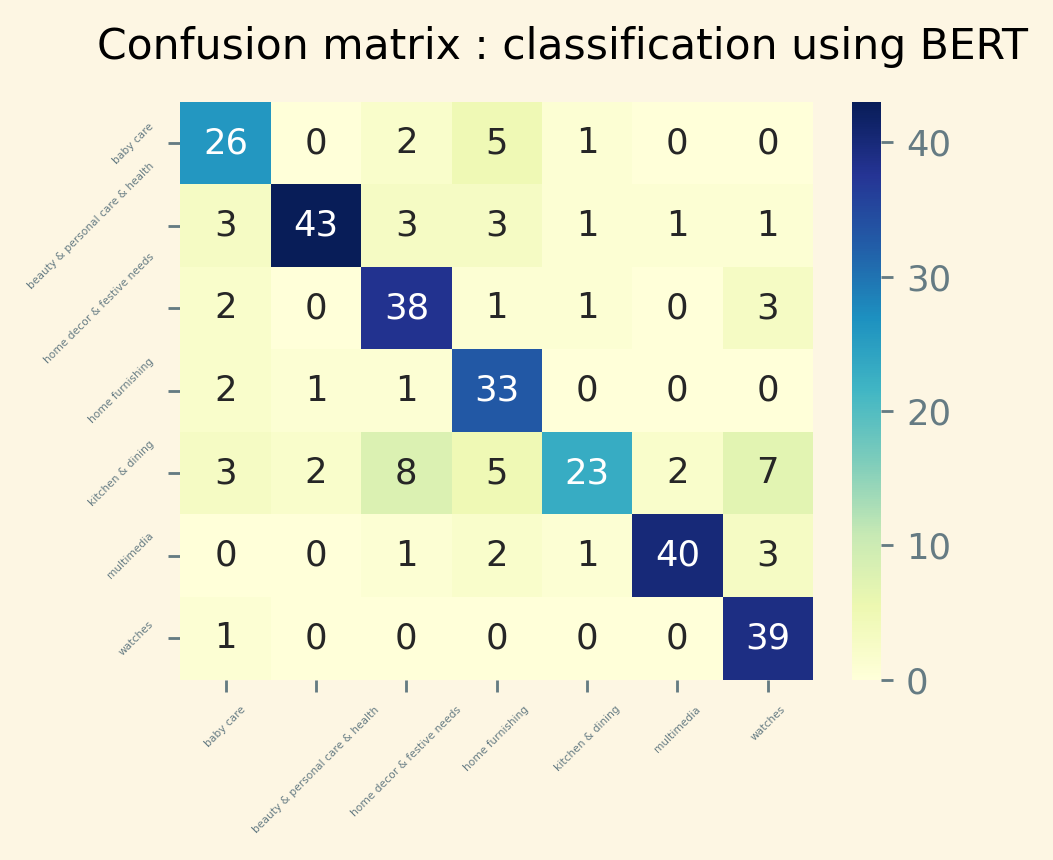

In [29]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=255,
)

sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification using BERT")
#
###

plt.show()


# Conclusion :

- While being heavier to implement than techniques such as BOW and TF-IDF, the BERT model shows promises, especially if we have additional training data in the future.
- BERT is here used as a sentence embedding technique (and not word embedding, although it can be used in this capacity), it performs way better than previously used word embedding techniques like FastText and Word2Vec.
- Although the performances are good, the best results as of now are achieved with sparse methods (BOW and TF-IDF). However, it is highly likely than Dense methods (such as BERT and Word2Vec for example) will outperform BOW and TF-IDF on a larger scale and that the computational costs of TF-IDF / BOW will increase dramatically as the data grows.
- BERT might be a good solution, even if the training is resource intensive.
- UniversalSentenceEncoder will be tried next and compared to the rest of the techniques we have studied thus far.